# **CNN Audio Classification**

**Imports**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
layers = tf.keras.layers
models = tf.keras.models

**Loading Dataset**

In [2]:
DATASET_PATH = "Audio Data"

train_cat = [os.path.join(DATASET_PATH, "train", "Cat", f)
             for f in os.listdir(os.path.join(DATASET_PATH, "train", "Cat"))
             if f.endswith(".wav")]

train_dog = [os.path.join(DATASET_PATH, "train", "Dog", f)
             for f in os.listdir(os.path.join(DATASET_PATH, "train", "Dog"))
             if f.endswith(".wav")]

test_cat = [os.path.join(DATASET_PATH, "test", "Cat", f)
            for f in os.listdir(os.path.join(DATASET_PATH, "test", "Cat"))
            if f.endswith(".wav")]

test_dog = [os.path.join(DATASET_PATH, "test", "Dog", f)
            for f in os.listdir(os.path.join(DATASET_PATH, "test", "Dog"))
            if f.endswith(".wav")]

print("Train Cats:", len(train_cat))
print("Train Dogs:", len(train_dog))
print("Test Cats:", len(test_cat))
print("Test Dogs:", len(test_dog))

train_files = train_cat + train_dog
test_files  = test_cat + test_dog

train_labels = ["cat"] * len(train_cat) + ["dog"] * len(train_dog)
test_labels  = ["cat"] * len(test_cat) + ["dog"] * len(test_dog)


Train Cats: 125
Train Dogs: 85
Test Cats: 39
Test Dogs: 28


**Audio Preprocessing**

In [3]:
SAMPLE_RATE = 22050
DURATION = 2
SAMPLES = SAMPLE_RATE * DURATION

def load_audio_mel(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    if len(y) < SAMPLES:
        y = np.pad(y, (0, SAMPLES - len(y)))
    else:
        y = y[:SAMPLES]

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, hop_length=512)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    return mel_db


**Visualizing**

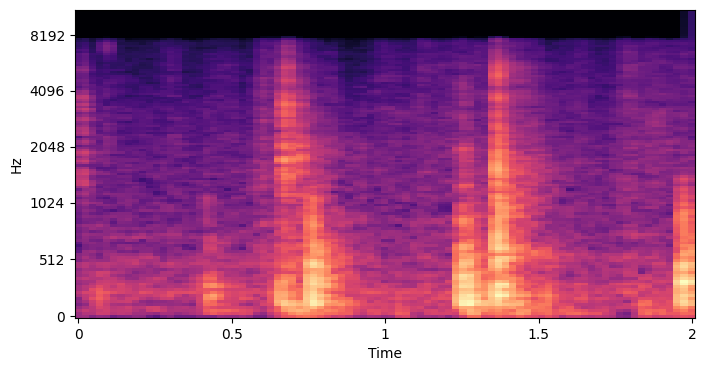

In [4]:
example = load_audio_mel(train_files[0])
plt.figure(figsize=(8,4))
librosa.display.specshow(example, sr=SAMPLE_RATE, hop_length=512, x_axis="time", y_axis="mel")
plt.show()


**Processing Entire Dataset**

In [5]:
X_train = np.array([load_audio_mel(f) for f in train_files])
X_test  = np.array([load_audio_mel(f) for f in test_files])

X_train = X_train[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (210, 128, 87, 1)
Test shape: (67, 128, 87, 1)


**Encoding Labels**

In [6]:
encoder = LabelEncoder()

y_train = encoder.fit_transform(train_labels)   # cat=0, dog=1
y_test  = encoder.transform(test_labels)

print("Encoded labels:", encoder.classes_)


Encoded labels: ['cat' 'dog']


**CNN Model**

In [7]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

model = models.Sequential([
    layers.Conv2D(16, (3,3), padding="same", activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


c:\Users\stsaa\Desktop\Deep-Learning\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 87, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 43, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 43, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       655,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 678,785 (2.59 MB)

 Trainable params: 678,785 (2.59 MB)

 Non-trainable params: 0 (0.00 B)

**Training**

In [8]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4952 - loss: 3.8539 - val_accuracy: 0.5821 - val_loss: 1.1454
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6143 - loss: 0.6976 - val_accuracy: 0.8209 - val_loss: 0.4053
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8000 - loss: 0.4499 - val_accuracy: 0.8806 - val_loss: 0.3189
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8810 - loss: 0.3232 - val_accuracy: 0.9104 - val_loss: 0.2543
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8762 - loss: 0.3090 - val_accuracy: 0.9254 - val_loss: 0.2496
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9143 - loss: 0.2420 - val_accuracy: 0.9254 - val_loss: 0.2266
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9190 - loss: 0.2352 - val_accuracy: 0.8657 - val_loss: 0.3750
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9095 - loss: 0.2161 - val_accuracy: 0.9104 - val_loss

**Metrics and Plots**

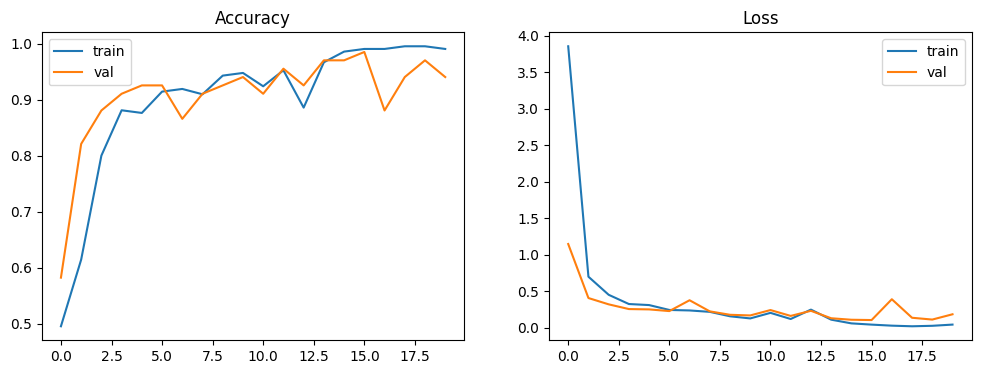

In [9]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.legend()

plt.show()


In [10]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.3f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9403 - loss: 0.1828 
Test Accuracy: 0.940


**Test**

In [11]:
def predict_audio(file_path):
    mel = load_audio_mel(file_path)
    mel = mel[np.newaxis, ..., np.newaxis]
    pred = model.predict(mel)[0][0]

    if pred > 0.5:
        print("Prediction: DOG")
    else:
        print("Prediction: CAT")

# Example
predict_audio("Audio Data/test/dog/dog_barking_62.wav")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction: DOG


ChatGPT was used to adapt this example [Link](https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab/)